Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'

In [3]:
# Split all data columns into 'categorical' and 'continuous'
x_cat_vs_cont = {'categorical': ['HeatSystem', 'HeatSource', 'BldgGrade', 'Condition'], 
                 'discrete': ['Stories', 'NbrLivingUnits', 'FinBasementGrade', 'Bedrooms', 'Bathrooms', 'Fireplaces'],
                 'continuous': ['SqFtTotLiving', 'SqFtTotBasement', 'SqFtGarageAttached','SqFtOpenPorch', 
                             'SqFtEnclosedPorch', 'SqFtDeck','BrickStone', 'YrBuilt', 'YrRenovated', 'SqFtUnfinished']}

## One-hot encode relevant categoricals

#### Starting with "HeatSystem"

In [4]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys, '\n')
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "") if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity', 'Radiant'] else x
heating = heating.apply(simplify)
print('\nImproved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'} 

Original breakdown:
ForcedAir     14148
HeatPump       1536
ElecBB         1124
Floor-Wall      564
HotWater        447
Radiant         261
Gravity          38
Other            25
Name: HeatSystem, dtype: int64

Improved categorization:
ForcedAir     14148
HeatPump       1536
ElecBB         1124
Floor-Wall      564
HotWater        447
Other           324
Name: HeatSystem, dtype: int64


#### Next, one-hot encode "Condition"

In [5]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x]
condition = df_main.Condition.apply(convert_to_keys)
print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}

Breakdown of conditions:
Average      11384
Good          4716
Very Good     1915
Fair           115
Poor            13
Name: Condition, dtype: int64


#### Next, one-hot encode "HeatSource"

In [6]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
print()
print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
print('\nImproved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)


Original breakdown:
Gas                  13138
Electricity           3186
Oil                   1738
Gas/Solar               40
Other                   31
Electricity/Solar        8
Oil/Solar                2
Name: HeatSource, dtype: int64

Improved categorization:
Gas            13138
Electricity     3186
Oil             1738
Other             81
Name: HeatSource, dtype: int64


In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SalePrice               18143 non-null  int64  
 1   NbrLivingUnits          18143 non-null  int64  
 2   Stories                 18143 non-null  float64
 3   BldgGrade               18143 non-null  int64  
 4   SqFtTotLiving           18143 non-null  int64  
 5   SqFtTotBasement         18143 non-null  int64  
 6   FinBasementGrade        18143 non-null  int64  
 7   SqFtGarageAttached      18143 non-null  int64  
 8   SqFtOpenPorch           18143 non-null  int64  
 9   SqFtEnclosedPorch       18143 non-null  int64  
 10  SqFtDeck                18143 non-null  int64  
 11  BrickStone              18143 non-null  int64  
 12  Bedrooms                18143 non-null  int64  
 13  YrBuilt                 18143 non-null  int64  
 14  YrRenovated             18143 non-null

In [11]:
# Run Step-wise selection algorithm to eliminate irrelevant features
X = df_main.drop(y, axis=1)
keepers = stepwise_selection(X, df_main[y], verbose=False)

# Determine which features were removed
removed = list(df_main.drop(y, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('Remaining features:', keepers)
print('Removed features:', removed)

df_main = df_main[[y] + keepers].copy()

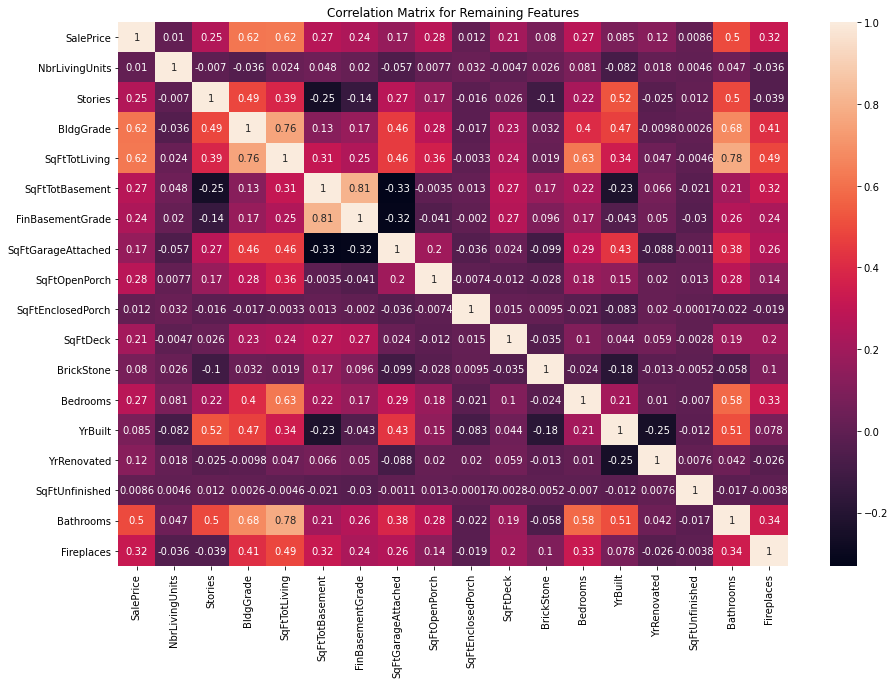

In [9]:
CorrMatrix = df_main.corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features');

In [8]:
#pd.plotting.scatter_matrix(df_main, figsize=(30,30));

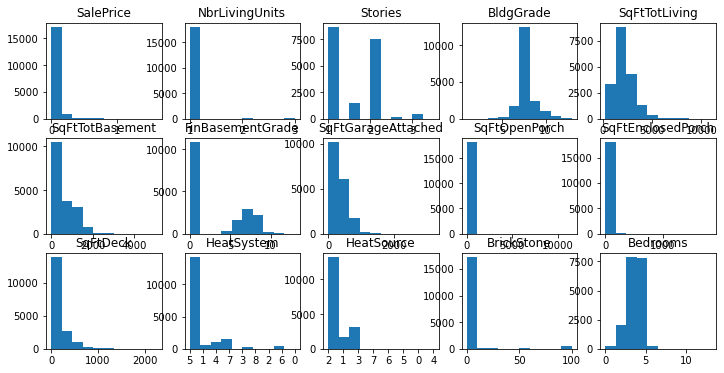

In [10]:
# Plot Histograms

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12,6))

for col, ax in zip(df_main.columns, axes.flatten()):
    ax.hist(df_main[col])
    ax.set_title(col)

In [19]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)

correlations

,Dependent,Feature,Correlation (abs)
0,SalePrice,BldgGrade,0.619727
1,SalePrice,SqFtTotLiving,0.586104
2,SalePrice,Bathrooms,0.442576
3,SalePrice,Bedrooms,0.286370
4,SalePrice,SqFtOpenPorch,0.236103
5,SalePrice,SqFtDeck,0.145828
6,SalePrice,HeatSystem,0.136113
7,SalePrice,SqFtGarageAttached,0.118583
8,SalePrice,YrBuilt,0.096138
9,SalePrice,HeatSource,0.078371


In [ ]:
xs = df_main.drop(y, axis=1).columns
model, df_main = produce_model(df_main, xs, y, 3)

# Check Assumptions

In [20]:
def check_assumptions(model, df, feature_to_plot=False):
    linearity(model, df, supress_figures=True)
    normality(model, df)
    homoscedacity(model, df)
    independence(model, df, supress_figures=True)   

    
def linearity(model, df, supress_figures=False):
    lr = linear_rainbow(model)
    p = lr[1]
    print('Linearity p-value (where null hypothesis = linear):', p)
    
    if supress_figures == False:
        sns.pairplot(df)
        plt.suptitle('Investigating Linearity of Inputs', y=1.05)
    return p


def normality(model, df, plot_feature=False):
    jb = sms.jarque_bera(model.resid)
    print('Normality of Residuals (where null hypothesis = normality): JB stat={}, JB stat p-value={}'.format(jb[0], jb[1]))
    
    if plot_feature != False:
        sm.graphics.qqplot(df[plot_feature], line='45', fit=True)
        plt.title('Normality of Residuals:', col);
    return jb[0], jb[1]    


def homoscedacity(model, df, plot_feature=False):
    bp = het_breuschpagan(model.resid, model.model.exog)
    p_lm, p_f = bp[1], bp[3]
    print("Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value={} and f-value's p-value={}".format(p_lm, p_f))
    
    if plot_feature != False:
        predicted = model.predict()
        error = df[y] - predicted
        plt.scatter(df[plot_feature], error, alpha=0.3, )
        plt.plot([df[plot_feature].min(), df[plot_feature].max()], [0,0], color='black')
        plt.xlabel(plot_feature)
        plt.ylabel("Error (Actual-Predicted)")
        plt.title('Homoscedacity of Residuals');
    return p_lm, p_f


# CITATION: function content taken from Flatiron School Study Group material
def independence(model, df, supress_figures=False):
    features = df.drop(y, axis=1).columns
    
    df_vif = pd.DataFrame()
    df_vif['Feature'] = features
    df_vif['VIF'] = [variance_inflation_factor(df.drop(y, axis=1).values, i) for i in range (len(features))]
    
    if supress_figures == False:
        CorrMatrix = df.corr()
        #plt.figure(figsize=(15,10))
        sns.heatmap(CorrMatrix, annot=True)
    print('\nVariance Inflation Factors:\n', df_vif)
    return df_vif

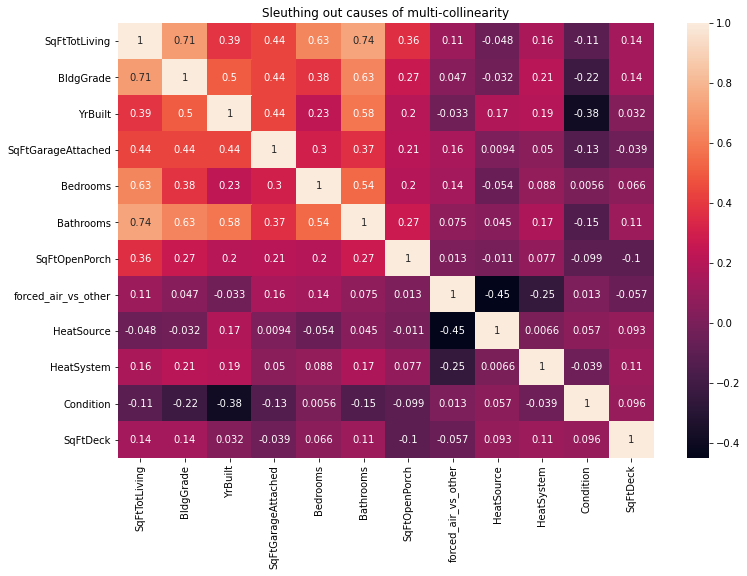

In [29]:
CorrMatrix = df_main.drop(['YrRenovated', 'SalePrice'], axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Sleuthing out causes of multi-collinearity');

## One-Hot encode HeatSystem feature

## Figure out how to achieve a low VIF

In [38]:
includes = ['YrBuilt', 'Bedrooms', 'SqFtOpenPorch']
vif = pd.DataFrame()
vif['VIF Factor'] =  [variance_inflation_factor(df_main[includes].values, i) for i in range(df_main[includes].shape[1])]
vif["features"] = df_main[includes].columns
vif

,VIF Factor,features
0,18.420172,YrBuilt
1,19.087627,Bedrooms
2,1.524891,SqFtOpenPorch


In [32]:
drops = ['YrRenovated', 'SalePrice']

vif = pd.DataFrame()
X_drops = df_main.drop(drops, axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X_drops.values, i) for i in range(X_drops.shape[1])]
vif["features"] = X_drops.columns
vif

,VIF Factor,features
0,29.764339,SqFtTotLiving
1,136.359446,BldgGrade
2,242.625889,YrBuilt
3,2.618630,SqFtGarageAttached
4,32.044711,Bedrooms
5,24.836717,Bathrooms
6,1.744297,SqFtOpenPorch
7,7.782368,forced_air_vs_other
8,23.861559,HeatSource
9,64.465045,HeatSystem


In [ ]:
features = df_main.drop([y, 'NbrLivingUnits'], axis=1).columns#['SqFtTotLiving', 'YrBuilt']
model, df = produce_model(df_main, features, y, 3, drop_zeros=False)
check_assumptions(model, df)

In [ ]:


fig, axes = plt.subplots(2, 5, figsize=(25,10))

df_x_continuous = df_main[x_cat_vs_cont['continuous']].copy()
for col, ax in zip(df_x_continuous.columns, axes.flatten()):
    df = pd.concat([df_main[y], df_x_continuous[col]], axis=1)
    cleaned = remove_df_extremes(df, devct=3, drop_zeros=True)
    ax.scatter(y = y, x = col, data=cleaned)
    ax.set_title(col)
    

    
    